In [2]:
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load ranked analysis with domains

ranked_df = pd.read_csv('./results/ranked_analysis_with_domains.csv', sep=',')
ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
0,S-EPMC6040727,1.5,1.333333,1.333333,1.2,0.000000,0.000000,1.333333,1.333333,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
1,Mendeley_pzp26k9fy7,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.400000,1.400000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
2,DRYAD_doi.org:10.5061:dryad.9r35r,0.0,0.000000,3.666667,11.0,22.000000,11.000000,0.000000,7.333333,22.0,22.000000,22.000000,2.444444,11.0,22.0,22.000000,22.000000,AIDS,immunology
3,veupathdb_DS_e8c4cf2187,0.0,0.000000,0.000000,0.0,2.200000,3.666667,0.000000,0.000000,0.0,1.833333,3.666667,0.000000,0.0,0.0,0.000000,1.100000,AIDS,immunology
4,Dataverse_10.5064_F6SF2T3N,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.857143,2.166667,0.000000,0.0,0.0,2.600000,4.333333,AIDS,immunology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,ZENODO_5044544,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.300000,1.625000,zika microcephaly,infectious disease
477,ZENODO_5008681,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.700000,zika microcephaly,infectious disease
478,S-EPMC6256666,1.7,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.0,0.0,0.000000,0.000000,zika microcephaly,infectious disease
479,IMMPORT_SDY1515_2,0.0,0.000000,0.000000,0.0,6.333333,9.500000,0.000000,0.000000,0.0,3.800000,9.500000,0.000000,0.0,0.0,2.375000,3.800000,sublingual immunotherapy,allergy


In [4]:
combination_order = ['original', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
                     'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13',
                     'c14', 'c15']

In [5]:
def compute_scores(df, combination_order):
    final_df = pd.DataFrame()

    for combi in combination_order:
        df_comb = df[['search term', combi]].copy()
        df_comb_sum = df_comb.groupby('search term').sum().reset_index()
        if final_df.empty:
            final_df = df_comb_sum
        else: 
            final_df = final_df.merge(df_comb_sum, on = 'search term')

    final_df.columns = ['search term'] + combination_order
    return final_df

In [6]:
def perform_wilcoxon_test(data):
    data = data.drop('search term', axis = 1)
    # Get the column names
    columns = data.columns
    
    # Initialize a list to hold the results
    results = []
    
    # Perform the Wilcoxon signed-rank test for each pair of columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = columns[i]
            col2 = columns[j]
            stat, p = wilcoxon(data[col1], data[col2])
            results.append((col1, col2, stat, p))
            
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results, columns=['set 1', 'set 2', 'statistic', 'p-value'])
    return results_df

In [7]:
def compare_scores(scores, columns):
    score_comparisons = {}
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            set1 = columns[i]
            set2 = columns[j]
            if scores[set1] > scores[set2]:
                score_comparisons[(set1, set2)] = set1
            else:
                score_comparisons[(set1, set2)] = set2
    return score_comparisons

In [8]:
def add_winner(row):
    set1, set2 = row['set 1'], row['set 2']
    return winners[(set1, set2)]

In [9]:
def swap_sets(row):
    s1_index = combination_order.index(row['set 1'])
    s2_index = combination_order.index(row['set 2'])
    if s2_index < s1_index:
        return pd.Series([row['set 1'], row['set 2'], row['p-value']])  
    else:
        return pd.Series([row['set 2'], row['set 1'], row['p-value']])

In [10]:
def create_heatmap_with_winners(df, title, filename):
    heatmap_data = df.pivot('set 1', 'set 2', 'p-value')

    # Reorder index and columns
    heatmap_data = heatmap_data.reindex(combination_order, axis = 0)
    heatmap_data = heatmap_data.reindex(combination_order, axis = 1)

    # Combine winner and p-value in the annotation
    formatted_text = np.empty(heatmap_data.shape, dtype = object)
    
    for i in range(len(combination_order)):
        for j in range(len(combination_order)):
            if not np.isnan(heatmap_data.iloc[i, j]):
                formatted_text[i, j] = "{}\n{:.3f}".format(df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['winner'].values[0], df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['p-value'].values[0])
        else:
            formatted_text[i, j] = ""

    # Create heatmap using seaborn
    sns.set(font_scale = 1.4)
    sns.set_style('white')
    plt.figure(figsize = (24, 12))
    sns.heatmap(heatmap_data, cmap='BuPu_r', annot=formatted_text, fmt="", cbar_kws={'label': 'p-values'})
    plt.savefig(f'../alternate_test/results/{filename}.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

In [11]:
cell_types_ranked_df = ranked_df.loc[ranked_df['domain'] == 'cell types']
cell_types_ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
121,S-EPMC6830784,2.000000,1.750000,0.000000,0.000,0.000000,0.000000,1.750000,0.000000,0.000000,0.000000,0.000000,1.750000,1.555556,0.000000,0.000000,0.000000,dendritic cells,cell types
122,Mendeley_tpdv3r7v57,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.857143,2.166667,1.857143,dendritic cells,cell types
123,GSE112082,0.000000,2.428571,5.666667,4.250,3.400000,2.428571,1.888889,5.666667,5.666667,4.250000,2.833333,1.888889,5.666667,8.500000,4.250000,3.400000,dendritic cells,cell types
124,IMMPORT_SDY282_1,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.222222,dendritic cells,cell types
125,GSE64124,0.000000,0.000000,0.000000,2.125,1.700000,0.000000,0.000000,0.000000,1.888889,1.888889,0.000000,0.000000,0.000000,0.000000,1.700000,0.000000,dendritic cells,cell types
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,GSE87483,0.000000,0.000000,0.000000,0.000,0.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,mast cells,cell types
445,GSE96695,0.000000,0.000000,0.000000,0.000,0.000000,1.888889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,mast cells,cell types
446,GSE165523,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.900000,0.000000,mast cells,cell types
447,S-EPMC6702076,2.571429,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.800000,0.000000,0.000000,0.000000,0.000000,mast cells,cell types


In [12]:
# Calculate scores per search term per combination

cell_types_scores_df = compute_scores(cell_types_ranked_df, combination_order)
cell_types_scores_df

,search term,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,dendritic cells,50.283333,52.356349,53.173810,52.938492,52.859921,53.717460,52.324603,53.077778,52.943651,52.829365,53.667460,52.324603,51.907937,52.251587,52.301587,52.829365
1,mast cells,58.796429,60.733333,62.641667,63.415873,62.585317,60.087698,60.173810,62.208333,63.597222,62.501984,61.967460,60.273810,61.834524,63.274206,62.896825,62.501984
2,pinealocyte,50.630556,52.030556,52.030556,52.030556,52.230556,50.046825,52.030556,52.030556,52.030556,52.230556,51.113492,52.030556,52.030556,52.030556,52.030556,52.230556
3,plasmacytoid dendritic cells,60.199603,62.363889,61.769048,61.538889,62.898810,63.688492,61.563889,61.757937,62.349603,62.683333,63.639286,61.563889,61.826587,61.885714,61.738889,63.074206


In [13]:
# Run Wilcoxon test

cell_types_wilcoxon_df = perform_wilcoxon_test(cell_types_scores_df)
cell_types_wilcoxon_df

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,set 1,set 2,statistic,p-value
0,original,c1,0.0,0.125000
1,original,c2,0.0,0.125000
2,original,c3,0.0,0.125000
3,original,c4,0.0,0.125000
4,original,c5,1.0,0.250000
...,...,...,...,...
115,c12,c14,1.0,0.285049
116,c12,c15,0.0,0.125000
117,c13,c14,1.0,0.285049
118,c13,c15,3.0,0.625000


In [14]:
# Export scores per search term

cell_types_scores_df.to_csv('../alternate_test/results/scores_cell_types.csv', index = False)

In [15]:
# Drop search term column

cell_types_scores_only_df = cell_types_scores_df.drop(columns = ['search term'])
cell_types_scores_only_df

,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,50.283333,52.356349,53.173810,52.938492,52.859921,53.717460,52.324603,53.077778,52.943651,52.829365,53.667460,52.324603,51.907937,52.251587,52.301587,52.829365
1,58.796429,60.733333,62.641667,63.415873,62.585317,60.087698,60.173810,62.208333,63.597222,62.501984,61.967460,60.273810,61.834524,63.274206,62.896825,62.501984
2,50.630556,52.030556,52.030556,52.030556,52.230556,50.046825,52.030556,52.030556,52.030556,52.230556,51.113492,52.030556,52.030556,52.030556,52.030556,52.230556
3,60.199603,62.363889,61.769048,61.538889,62.898810,63.688492,61.563889,61.757937,62.349603,62.683333,63.639286,61.563889,61.826587,61.885714,61.738889,63.074206


In [16]:
# Compute total scores per combination

cell_types_total_scores_df = cell_types_scores_only_df.sum()
cell_types_total_scores_df

original    219.909921
c1          227.484127
c2          229.615079
c3          229.923810
c4          230.574603
c5          227.540476
c6          226.092857
c7          229.074603
c8          230.921032
c9          230.245238
c10         230.387698
c11         226.192857
c12         227.599603
c13         229.442063
c14         228.967857
c15         230.636111
dtype: float64

In [18]:
# Determine winners by comparing combination scores

winners = compare_scores(cell_types_total_scores_df, combination_order)
winners

{('original', 'c1'): 'c1',
 ('original', 'c2'): 'c2',
 ('original', 'c3'): 'c3',
 ('original', 'c4'): 'c4',
 ('original', 'c5'): 'c5',
 ('original', 'c6'): 'c6',
 ('original', 'c7'): 'c7',
 ('original', 'c8'): 'c8',
 ('original', 'c9'): 'c9',
 ('original', 'c10'): 'c10',
 ('original', 'c11'): 'c11',
 ('original', 'c12'): 'c12',
 ('original', 'c13'): 'c13',
 ('original', 'c14'): 'c14',
 ('original', 'c15'): 'c15',
 ('c1', 'c2'): 'c2',
 ('c1', 'c3'): 'c3',
 ('c1', 'c4'): 'c4',
 ('c1', 'c5'): 'c5',
 ('c1', 'c6'): 'c1',
 ('c1', 'c7'): 'c7',
 ('c1', 'c8'): 'c8',
 ('c1', 'c9'): 'c9',
 ('c1', 'c10'): 'c10',
 ('c1', 'c11'): 'c1',
 ('c1', 'c12'): 'c12',
 ('c1', 'c13'): 'c13',
 ('c1', 'c14'): 'c14',
 ('c1', 'c15'): 'c15',
 ('c2', 'c3'): 'c3',
 ('c2', 'c4'): 'c4',
 ('c2', 'c5'): 'c2',
 ('c2', 'c6'): 'c2',
 ('c2', 'c7'): 'c2',
 ('c2', 'c8'): 'c8',
 ('c2', 'c9'): 'c9',
 ('c2', 'c10'): 'c10',
 ('c2', 'c11'): 'c2',
 ('c2', 'c12'): 'c2',
 ('c2', 'c13'): 'c2',
 ('c2', 'c14'): 'c2',
 ('c2', 'c15'): 'c15

In [19]:
# Add winners to Wilcoxon test results

cell_types_wilcoxon_df['winner'] = cell_types_wilcoxon_df.apply(add_winner, axis = 1)
cell_types_wilcoxon_df

,set 1,set 2,statistic,p-value,winner
0,original,c1,0.0,0.125000,c1
1,original,c2,0.0,0.125000,c2
2,original,c3,0.0,0.125000,c3
3,original,c4,0.0,0.125000,c4
4,original,c5,1.0,0.250000,c5
...,...,...,...,...,...
115,c12,c14,1.0,0.285049,c14
116,c12,c15,0.0,0.125000,c15
117,c13,c14,1.0,0.285049,c13
118,c13,c15,3.0,0.625000,c15


In [20]:
cell_types_wilcoxon_df['winner'].value_counts()

c8     15
c15    14
c4     13
c10    12
c9     11
c3     10
c2      9
c13     8
c7      7
c14     6
c12     5
c5      4
c1      3
c11     2
c6      1
Name: winner, dtype: int64

In [21]:
cell_types_wilcoxon_df[cell_types_wilcoxon_df['p-value'] <= 0.05]

,set 1,set 2,statistic,p-value,winner


In [22]:
# Export Wilcoxon test results

cell_types_wilcoxon_df.to_csv('../alternate_test/results/wilcoxon_with_winners_cell_types.csv', index = False)

In [23]:
# Rearrange rows so that heatmap cells are rendered below the main diagonal

cell_types_wilcoxon_df[['set 1', 'set 2', 'p-value']] = cell_types_wilcoxon_df.apply(swap_sets, axis = 1)

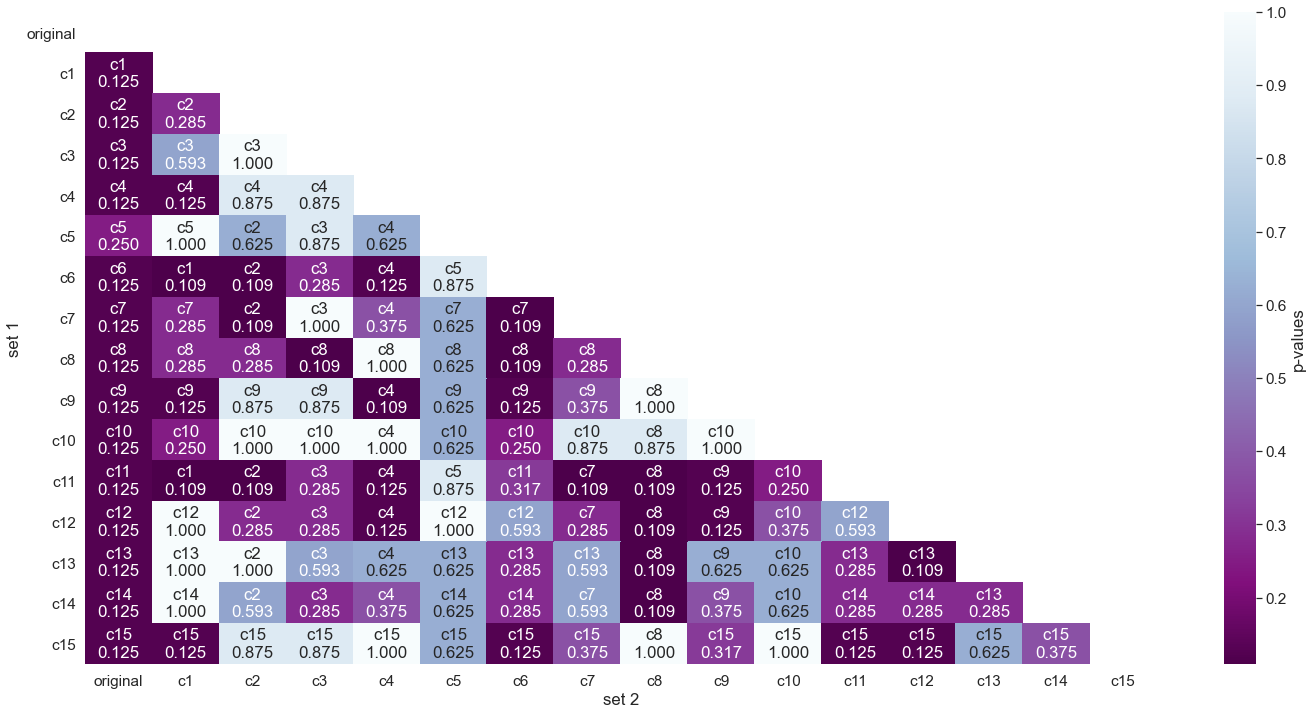

In [25]:
# Generate heatmap of p-values with winners

create_heatmap_with_winners(cell_types_wilcoxon_df, 'Heatmap of p-values | Wilcoxon test', 
                            'wilcoxon_heatmap_with_winners_cell_types')